# Section 1: Imports

In [28]:
# basics
import pandas as pd
import numpy as np
import random
import joblib

# plotting
import matplotlib.pyplot as plt
import optuna.visualization as vis
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# models
from src import utils
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import optuna

# sys
import os
import gc
import sys


import logging
optuna.logging.set_verbosity(optuna.logging.INFO)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


def is_kaggle_env():
    return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if is_kaggle_env():
    print("This is running inside Kaggle!")
else:
    print("This is running outside Kaggle!")


if not is_kaggle_env():
    DATA_DIR = "../data/"
else:
    DATA_DIR = "/kaggle/input/optiver-trading-at-the-close/"

if not is_kaggle_env():
    MODEL_DIR = "../models/"
else:
    MODEL_DIR = None

This is running outside Kaggle!


In [29]:
# CONSTANTS
VAL_SIZE = 0.05
is_cv = False
is_interactive = not is_cv

# Section 2: Data Preprocessing

In [30]:
def read_csv():
    train = pd.read_csv(DATA_DIR + 'train.csv')
    # revealed_targets = pd.read_csv(DATA_DIR + 'example_test_files/revealed_targets.csv')
    # test = pd.read_csv(DATA_DIR + 'example_test_files/test.csv')
    # sample_submission = pd.read_csv(DATA_DIR + 'example_test_files/sample_submission.csv')
    return train

train = read_csv()

In [31]:
def train_test_split(df, total_days=481, test_days=20):
    test_dates = [
        # *[ random.randint(0,480)  for _ in range(3)]
        *[ _ for _ in range(total_days-test_days, total_days)]
    ]
    test = df.loc[df["date_id"].isin(test_dates)]
    train = df.loc[~df["date_id"].isin(test_dates)]

    return train, test

train, test = train_test_split(train)

In [32]:
train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [33]:
train.shape

(5017980, 17)

In [34]:
train.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [35]:
train.loc[train["wap"].isna()] 

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774999,19,438,500,NaN,-1,NaN,NaN,NaN,NaN,NaN,115491.18,NaN,1990.10,NaN,3.319979,24140,438_500_19
4775199,19,438,510,NaN,-1,NaN,NaN,NaN,NaN,NaN,189040.50,NaN,26283.84,NaN,-5.049705,24141,438_510_19
4775399,19,438,520,NaN,-1,NaN,NaN,NaN,NaN,NaN,1392.93,NaN,43799.80,NaN,-0.110269,24142,438_520_19
4775599,19,438,530,NaN,-1,NaN,NaN,NaN,NaN,NaN,13531.32,NaN,26881.20,NaN,-1.689792,24143,438_530_19


In [36]:
display(train["date_id"].unique())
display(test["date_id"].unique())


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

array([461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
       474, 475, 476, 477, 478, 479, 480])

## Section 2A: Train_Val_Split

> TODO: train_test_split

In [37]:
%%time
def train_val_split(df):
    n_train_val_dates = df["date_id"].nunique()
    val_size = int(VAL_SIZE * n_train_val_dates)
    train_size = n_train_val_dates - val_size
    
    print("n_train_val_dates:", n_train_val_dates)
    print("train_size:", train_size)
    print("val_size:", val_size)
    
    _temp_train = df.loc[df["date_id"].isin([ d for d in range(train_size)])]
    _temp_val = df.loc[~df["date_id"].isin([ d for d in range(train_size)])]
    y_train = _temp_train['target'].values
    X_train = _temp_train.drop(columns='target')
    y_val = _temp_val['target'].values
    X_val = _temp_val.drop(columns='target')
    print("y_train.shape:", y_train.shape)
    print("X_train.shape:", X_train.shape)
    print("y_val.shap:", y_val.shape)
    print("X_val.shape:", X_val.shape)

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = train_val_split(train)

n_train_val_dates: 461
train_size: 438
val_size: 23
y_train.shape: (4764980,)
X_train.shape: (4764980, 16)
y_val.shap: (253000,)
X_val.shape: (253000, 16)
CPU times: user 203 ms, sys: 89.1 ms, total: 292 ms
Wall time: 288 ms


## Section 2B: Feature Engineering
> TODO: Feature Engin.


In [38]:
def get_volume_features(df, is_save=False):
    cols = ['med_volume','max_volume',
              'min_volume','std_volume', 'first_5min_volume', 'last_5min_volume']
    _volume_features = pd.DataFrame(
        columns = cols,
        index = range(0, 200,1)
    )
    
    _volume_features["med_volume"] = df[["stock_id","bid_size","ask_size"]].groupby("stock_id")[["bid_size","ask_size"]].median().sum(axis=1).values.flatten()
    # features.append("med_volume")
    
    _volume_features['max_volume'] = df.groupby('stock_id')['bid_size'].max() + df.groupby('stock_id')['ask_size'].max().values.flatten()
    # features.append("max_volume")
    
    _volume_features['min_volume'] = df.groupby('stock_id')['bid_size'].min() + df.groupby('stock_id')['ask_size'].min().values.flatten()
    # features.append("min_volume")
    
    _volume_features['std_volume'] = df.groupby('stock_id')['bid_size'].std() + df.groupby('stock_id')['ask_size'].std().values.flatten()
    # features.append("std_volume")
    
    _volume_features['first_5min_volume'] = df.loc[(df['far_price'].isna()) | (df['near_price'].isna()),['stock_id', "bid_size", "ask_size"]].groupby('stock_id')[["bid_size", "ask_size"]].median().sum(axis=1).values.flatten()
    # features.append("first_5min_volume")
    
    _volume_features['last_5min_volume'] = df[["stock_id",'bid_size','ask_size','near_price','far_price']].dropna().groupby('stock_id')[['bid_size','ask_size']].median().sum(axis=1).values.flatten()
    # features.append("last_5min_volume")

    if is_save:
        _volume_features.to_csv("VolumeFeatures.csv")

    gc.collect()
    return cols, _volume_features


In [39]:
def rolling_features(df, short_window_size):
    rolling_features = [
        'bid_size', 'ask_size', 'bid_price', 'ask_price', 
        'imbalance_size', 'matched_size', 'wap',
        "bid-ask_price_spread","bid-ask_size_spread"
    ]
    for feature in rolling_features:
        # -------------- Exponentially Weighted Moving (EWM) Calculations -------------- #
        #Rolling Std
        df[f"{feature}_ewm_std_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.ewm(span=short_window_size, adjust=False).std())
        # Rolling Mean
        df[f"{feature}_ewm_mean_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.ewm(span=short_window_size, adjust=False).mean())

        # -------------- Simple Moving (SM) Calculations --------------  #
        # Rolling Median
        df[f"{feature}_roliing_median_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.rolling(window=short_window_size, min_periods=1).median())

        # Rolling Max
        df[f"{feature}_rolling_max_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.rolling(window=short_window_size, min_periods=1).max())

        # Rolling Min
        df[f"{feature}_rolling_min_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.rolling(window=short_window_size, min_periods=1).min())

        # RollingSkewness
        df[f"{feature}_rolling_skew_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.rolling(window=short_window_size, min_periods=1).skew())

        # Rolling Kurtosis
        df[f"{feature}_rolling_kurt_(short_window_size)"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.rolling(window=short_window_size, min_periods=1).kurt())

        # Rolling Trend using Linear Regression Slope
        df[f"{feature}_rolling_slope_{short_window_size}"] = df.groupby("stock_id")[feature] \
                .transform(lambda x: x.rolling(window=short_window_size, min_periods=1).apply(
                    lambda y: np.polyfit(np.arange(len(y)), y, 1)[0] if len(y) >= 10 else np.nan
                ))

    return df

def log_return_wap(df):
    df["wap_log_return"] = df.groupby("stock_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))
    return df  

def add_med(df, volume_features):
    df = df.merge(volume_features, how="left", left_on="stock_id", right_index=True)
    return df

def feature_eng(df, is_test=False):
    feature_cols = []
    
    #------------ Fixed Features -------------#
    feature_cols.append("imbalance1")
    df["imbalance1"] = (df["bid_size"] - df["ask_size"]) / (df["bid_size"] + df["ask_size"])

    feature_cols.append("imbalance2")
    df["imbalance2"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])

    feature_cols.append("imbalance_ratio")
    df["imbalance_ratio"] = df["imbalance_size"] / df["matched_size"]

    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]

    for i, price_a in enumerate(prices):
        for j, price_b in enumerate(prices):
            if i > j:
                feature_cols.append(f"{price_a}-{price_b}")
                df[f"{price_a}-{price_b}"] = (df[price_a] - df[price_b]).astype(np.float32)
                feature_cols.append(f"{price_a}*{price_b}")
                df[f"{price_a}*{price_b}"] = (df[price_a] * df[price_b]).astype(np.float32)
                feature_cols.append(f"imbalance_{price_a}_{price_b}")
                df[f"imbalance_{price_a}_{price_b}"] = (df[price_a] - df[price_b]) / (df[price_a] + df[price_b])

    for i, price_a in enumerate(prices):
        for j, price_b in enumerate(prices):
            for k, price_c in enumerate(prices):
                if i>j and j>k:
                    temp_df = df[[price_a, price_b, price_c]]
                    max_val = temp_df.max(axis=1)
                    min_val = temp_df.min(axis=1)
                    mid_val = temp_df.sum(axis=1) - max_val - min_val

                    imbalance_column_name = f"imbalance_{price_a}_{price_b}_{price_c}"
                    feature_cols.append(imbalance_column_name)
                    df[imbalance_column_name] = (max_val - mid_val) / (mid_val - min_val)

    feature_cols.append("volume")
    df["volume"] = df["bid_size"] + df["ask_size"]

    feature_cols.append("higher_than_normal_volume")
    df["higher_than_normal_volume"] = np.where(df["volume"] > df["med_volume"], 1, 0) # one-hot encoding
    
    feature_cols.append("ask_priceXsize")
    feature_cols.append("bid_priceXsize")
    df["ask_priceXsize"] = df["ask_price"] * df["ask_size"]
    df["bid_priceXsize"] = df["bid_price"] * df["bid_size"]

    feature_cols.append("bid-ask_size_spread")
    feature_cols.append("bid-ask_price_spread")
    df["bid-ask_size_spread"] = df["bid_size"] - df["ask_size"]
    df["bid-ask_price_spread"] = df["bid_price"] - df["ask_price"]
    
    feature_cols.append("bid/ask_size")
    feature_cols.append("bid/ask_price")
    df["bid/ask_size"] = df["bid_size"].div(df["ask_size"])
    df["bid/ask_price"] = df["bid_size"].div(df["ask_size"])



    gc.collect()

    return feature_cols, df


In [40]:
%%time
def tutorial():
    features = list(X_train)
    _cols, volume_features = get_volume_features(X_train)
    features.extend(_cols)
    
    data = X_train.dropna(subset=['wap']).reset_index(drop=True)
    data = add_med(data, volume_features=volume_features)
    _cols, data = feature_eng(data)
    features.extend(_cols)
    data = log_return_wap(data)
    data = rolling_features(data,20)
    
    gc.collect()
    display(data.info())

# tutorial()

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 15.7 µs


In [41]:
_, VOLUME_FETURES = get_volume_features(X_train)
def feat_eng(df, do_rolling=True):
    cols = [c for c in df.columns if c not in ['row_id', 'time_id']] # compatible for training, test and inference
    df = df[cols]
    ############## feature_engineering ##############
    # df = df.dropna(subset=['wap']).reset_index(drop=True)
    df = add_med(df, volume_features=VOLUME_FETURES)
    _, df = feature_eng(df)

    if do_rolling: # rolling feature should be called seperately
        df = log_return_wap(df)
        df = rolling_features(df, 20)
        
    df.drop(columns=[
        'date_id', 
    ], inplace=True)
        
    gc.collect()
    
    return df


## Ready Xy

In [42]:
%%time
X_train_path = DATA_DIR + f"X_train_{int(VAL_SIZE*100)}_{20}.parquet"
if not os.path.exists( X_train_path):
    X_train = feat_eng(X_train)
    X_train.to_parquet(X_train_path, index=False)
else:
     X_train = pd.read_parquet(X_train_path)
    
X_val_path = DATA_DIR + f"X_val_{int(VAL_SIZE*100)}_{20}.parquet"
if not os.path.exists( X_train_path):
    X_val = feat_eng(X_val)
    X_val.to_parquet(X_val_path, index=False)
else:
    X_val = pd.read_parquet(X_val_path)
# y_train
# y_val

print("y_train.shape:", y_train.shape)
print("X_train.shape:", X_train.shape)
print("y_val.shape:", y_val.shape)
print("X_val.shape:", X_val.shape)
display(X_train)

y_train.shape: (4764980,)
X_train.shape: (4764980, 168)
y_val.shape: (253000,)
X_val.shape: (253000, 168)


,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,bid-ask_price_spread_rolling_kurt_(short_window_size),bid-ask_price_spread_rolling_slope_20,bid-ask_size_spread_ewm_std_20,bid-ask_size_spread_ewm_mean_20,bid-ask_size_spread_roliing_median_20,bid-ask_size_spread_rolling_max_20,bid-ask_size_spread_rolling_min_20,bid-ask_size_spread_rolling_skew_20,bid-ask_size_spread_rolling_kurt_(short_window_size),bid-ask_size_spread_rolling_slope_20
0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,...,NaN,NaN,NaN,52158.470000,52158.470,52158.47,52158.47,NaN,NaN,NaN
1,1,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,...,NaN,NaN,NaN,-17372.050000,-17372.050,-17372.05,-17372.05,NaN,NaN,NaN
2,2,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,...,NaN,NaN,NaN,18961.000000,18961.000,18961.00,18961.00,NaN,NaN,NaN
3,3,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,...,NaN,NaN,NaN,-476707.500000,-476707.500,-476707.50,-476707.50,NaN,NaN,NaN
4,4,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,...,NaN,NaN,NaN,16051.440000,16051.440,16051.44,16051.44,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764975,195,540,4118733.60,-1,0.998286,69121463.84,0.997424,0.997532,0.998286,53192.58,...,19.982828,-5.458647e-07,50465.555809,-31054.514762,-29821.620,56811.05,-159838.33,-0.362964,0.427986,-1317.864617
4764976,196,540,245611.22,1,0.999295,9184162.87,0.999531,0.999295,0.999059,158035.02,...,19.996081,2.639098e-06,57346.895852,-30243.509057,-4802.525,106600.91,-132324.71,0.097071,-0.086625,-6474.103120
4764977,197,540,310254.40,1,1.000413,9522475.81,1.002180,1.001120,1.000295,41775.72,...,-0.081985,2.304511e-06,29106.450446,32665.549351,26777.870,94946.80,-9075.68,0.664842,-0.262788,512.841970
4764978,198,540,8923920.72,-1,0.999484,86617514.91,0.998285,0.998524,0.999484,1861803.92,...,-2.184152,-4.135338e-08,495406.130157,403037.431314,198567.670,1544251.19,-217780.79,1.702461,3.911915,45266.420617


CPU times: user 4.01 s, sys: 16.8 s, total: 20.8 s
Wall time: 2.12 s


# Section 3: Train Model

> TODO: Hyperparameters Tuning (CV),
Optimizer,
Loss Function,
Learning Rate Scheduler,

In [43]:
def combine_studies():
    study_name = "baseline"
    storage_name = "sqlite:///optuna_study.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)
    
    study_name = "baseline-concurrent"
    storage_name = "sqlite:///optuna_study.db"
    study_concurrent = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)
    
    combined_study = optuna.create_study(direction='minimize', study_name='combined_study')
    
    # Add all the trials from study1 into the combined_study
    for trial in study.trials:
        combined_study.add_trial(trial)
    
    # Add all the trials from study2 into the combined_study
    for trial in study_concurrent.trials:
        combined_study.add_trial(trial)

# combine_studies()

In [47]:
%%time
def custom_logging(env):
    """Custom callback for logging."""
    step = env.iteration
    train_loss = env.evaluation_result_list[0][2]  # Index changed to 2 for the actual score
    val_loss = env.evaluation_result_list[1][2]  # Index changed to 2 for the actual score

    sys.stdout.write("\r[{}], train_loss: {:.4f}, val_loss: {:.4f}".format(step, train_loss, val_loss))
    sys.stdout.flush()
    if step % 200 == 0:
        print()

def get_model():
    params = {
        'learning_rate': 0.0018911599330521175, 
        'max_depth': 22, 
        'num_leaves': 820, 
        'reg_alpha': 4.747976520869337e-08, 
        'reg_lambda': 1.801704929775981e-08,
        'n_estimators': 10000,
        'objective': 'mae',
        'random_state': 42,
        'verbose': -1
    }
    m = lgb.LGBMRegressor(**params)
    return m

def train_model(model, X_train, y_train, X_val, y_val):
    h = model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        # eval_names=["val", "train"],
        eval_metric='mae', 
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True, first_metric_only=True),
            custom_logging, # Custom callback for logging
        ],  
    )
    print()
    # display(h)
    return model


def objective(trial):
    # Define hyperparameter search space
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'n_estimators': 10000,  # keep this fixed
        'objective': 'mae',
        'random_state': 42,
        'verbose': -1
    }
    m = lgb.LGBMRegressor(**params)
    
    # Custom logging callback removed for simplicity here
    # You can add it back if you want to see logs for each trial
    h = train_model(m, X_train, y_train, X_val, y_val)
    
    # Return the best validation MAE
    val_mae = h.best_score_['valid_1']['l1']
    return val_mae


TRAIN = False
model_path = MODEL_DIR + 'lgbm_model.pkl'
# is_interactive = False
if is_interactive and TRAIN:
    m = get_model()
    m = train_model(m, X_train, y_train, X_val, y_val)
    joblib.dump(m, model_path)
elif is_interactive:
    m = joblib.load(model_path)
else:
    # Create a new study or load an existing study
    study_name = "baseline"
    storage_name = "sqlite:///optuna_study.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)
    study.optimize(objective, n_trials=20, show_progress_bar=True)  # You can change n_trials based on your requirements
    print('Best hyperparameters: ', study.best_params)

CPU times: user 1.37 s, sys: 163 ms, total: 1.53 s
Wall time: 434 ms


min training loss: 6.0370481838250045
min validation loss: 5.969316296637052


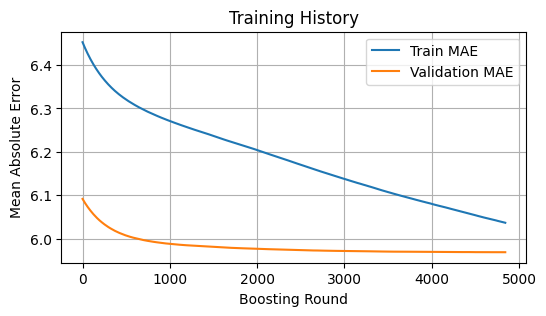

In [48]:
# plot training history
def dict_portion(d, start=None, last=None):
    out = {}
    for key, _ in d.items():
        for k, values in _.items():
            if last:
                if not key in out:
                    out[key] = {}
                if not k in out[key]:
                    out[key][k] = []
                out[key][k] = values[-last:]
    return out

def plt_history(evals_result):
    plt.figure(figsize=(6, 3))
    plt.plot(evals_result['training']['l1'], label='Train MAE')
    plt.plot(evals_result['valid_1']['l1'], label='Validation MAE')
    plt.xlabel('Boosting Round')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()


def plt_study(study):
    import optuna.visualization as vis
    # Plot optimization history
    fig = vis.plot_optimization_history(study)
    
    # Plot hyperparameter importance
    fig2 = vis.plot_param_importances(study)
    
    # Plot interaction among hyperparameters (for example, between 'learning_rate' and 'max_depth')
    # vis.plot_interactions(study, params=['learning_rate', 'max_depth'])
    fig3 = vis.plot_contour(study, params=['learning_rate', 'max_depth'])

    fig.show()
    fig2.show()
    fig3.show()

if is_interactive:
    try:
        print("min training loss:", min(m.evals_result_['training']['l1']))
        print("min validation loss:", min(m.evals_result_['valid_1']['l1']))
        plt_history(m.evals_result_)
        # plt_history(dict_portion(m.evals_result_, last=200))
    except Exception as e:
        display(e)
        print("plotting is not ready")
else:
    STUDY = combined_study
    print('Best hyperparameters: ', STUDY.best_params)
    plt_study(STUDY)


## Section 3a: Inspect Model
> TODO: Inspect Training results ( Overfit/underfit)

In [21]:
def display_feature_importances(m, feature_cols):
    display(sorted(list(zip(m.feature_importances_, feature_cols))))
    feat_imp = pd.Series(m.feature_importances_, index=feature_cols).sort_values()
    print('Columns with poor contribution', feat_imp[feat_imp<100].index)

    # Sorting the values for better visualization
    # plt.figure(figsize=(10, 16))
    # feat_imp.plot(kind='barh')
    # plt.title('Feature Importances')
    # plt.xlabel('Importance Score')
    # plt.ylabel('Features')
    # # plt.tight_layout()
    # plt.show()

if is_interactive:
    display_feature_importances(m, X_train.columns)

[(0, 'bid/ask_price'),
 (588, 'higher_than_normal_volume'),
 (3241, 'imbalance_far_price_reference_price'),
 (3251, 'bid/ask_size'),
 (3289, 'imbalance_wap_far_price'),
 (3704, 'imbalance_bid_price_far_price'),
 (3706, 'imbalance_ask_price_far_price'),
 (3940, 'bid-ask_price_spread'),
 (4150, 'ask_priceXsize'),
 (4189, 'bid_priceXsize'),
 (4794, 'wap-far_price'),
 (5605, 'imbalance_near_price_reference_price'),
 (5613, 'imbalance_wap_bid_price_far_price'),
 (5690, 'imbalance_wap_far_price_reference_price'),
 (5775, 'imbalance_wap_near_price_reference_price'),
 (5964, 'imbalance_bid_price_ask_price'),
 (6000, 'imbalance_wap_bid_price'),
 (6007, 'far_price-reference_price'),
 (6094, 'ask_price-far_price'),
 (6100, 'imbalance_wap_bid_price_ask_price'),
 (6164, 'wap*far_price'),
 (6223, 'imbalance_wap_ask_price_far_price'),
 (6279, 'bid_price-far_price'),
 (6297, 'wap*near_price'),
 (6343, 'imbalance1'),
 (6730, 'imbalance_wap_ask_price'),
 (6920, 'ask_size'),
 (7068, 'bid_size'),
 (7079, 

Columns with poor contribution Index(['bid/ask_price'], dtype='object')


In [22]:
m

LGBMRegressor(learning_rate=0.0018911599330521175, max_depth=22,
              n_estimators=10000, num_leaves=820, objective='mae',
              random_state=42, reg_alpha=4.747976520869337e-08,
              reg_lambda=1.801704929775981e-08, verbose=-1)

## Section 3b: Test Model

In [23]:
answer = test[["row_id", "target"]]
test = test.drop(columns='target')

In [24]:
test.shape

(220000, 16)

In [25]:
counts = test.groupby(["date_id", "seconds_in_bucket"]).size().reset_index(name="count")
counts.shape[0]

1100

In [26]:
class Inferencer:
    def __init__(self, use_zero_sum=True, model=None):
        self.user_zero_sum = use_zero_sum
        if model is None:
            raise Exception("model is needed")
        else:
            self.model = model
        self.data_history = None
        self.computed_data_history = None
    
    def predict(self, test, revealed_targets, sample_prediction):
        _test = self._feature_engineering(test).reset_index(drop=True)
        _prediction = self._predict(_test) # np.ndarray
        _sample_prediction = sample_prediction.reset_index(drop=True)
        _sample_prediction.loc[:, ["target"]] = _prediction

        if self.user_zero_sum:
            _sample_prediction = self._zero_sum(_test, _sample_prediction)

        return _sample_prediction

    ############## modify here ##############
    def mae(self, prediction, answer):
        return f"{mean_absolute_error(prediction, answer)}"
    
    def _feature_engineering(self, df):
        # pad the df with previously seen data for rolling windows
        if self.computed_data_history is None:
            self.computed_data_history = []

        # first calculate non rolling data
        df = feat_eng(df, do_rolling=False)

        # then concat and run rolling data
        data = pd.concat([
            *self.computed_data_history[-20:],
            df,
        ], ignore_index=True)
        data = log_return_wap(data)
        data = rolling_features(data, 20)
        
        df = data.iloc[-len(df):]
        self.computed_data_history.append(df)
        if len(self.computed_data_history) > 20:
            self.computed_data_history = self.computed_data_history[-20:]

        return df

    def _predict(self, df):
        return self.model.predict(df)
    
    def _zero_sum(self, test_df, sample_prediction_df): 
    #    I got this idea from https://github.com/gotoConversion/goto_conversion/
        prices = sample_prediction_df['target']
        volumes = test_df.loc[:,'bid_size'] + test_df.loc[:,'ask_size']

        std_error = np.sqrt(volumes)
        step = np.sum(prices)/np.sum(std_error)
        sample_prediction_df["target"] = prices-std_error*step
        return sample_prediction_df


In [27]:
%%time
for i in range(0, 2):
    inferencer = Inferencer(use_zero_sum=i==1, model=m)

    p = utils.mock_inference(test_df=test, inferencer=inferencer, fast=True)

    mae = inferencer.mae(p["target"], answer["target"])
    
    print("W:" if i==1 else "W/O:", mae)

W/O: 5.67643148685637
W: 5.67671662982959
CPU times: user 20min 24s, sys: 5.81 s, total: 20min 30s
Wall time: 2min 32s


In [19]:
''' Target 20231022 : 5.33
Using Mean
All days: 6.407540676345479
Last 20 days: 5.7897345368151605
Last 43-21 days: 6.092
------------
LGBMRegressor(learning_rate=0.018052307589575444, max_depth=9, n_estimators=700,
              num_leaves=442, objective='mae', random_state=42,
              reg_alpha=0.02216069565875271, reg_lambda=0.01223572246957101)

random 3  days: 6.153916090584697 | without zero_sum: 6.161420362084113
random 10 days: 6.16786915119617  | without zero_sum: 6.1714487952339665
random 20 days: 6.125230246787904 | without zero_sum: 6.12698
------------ 
last   3  days: 5.206188277021122 | without zero_sum: 5.209686931764142
last   6  days: 5.286582280836906 | without zero_sum: 5.295390499880226
last   20 days: 5.699853806473179 | without zero_sum: 5.702566553944518
------------ val_size = 0.2 ---------
last   10 days: 5.54128866505819  | without zero_sum: 5.547697604544385
last   20 days: 5.709074974677831 | without zero_sum: 5.71229106199595
------------ val_size = 0.2  | early stopping 100, n_t = 10000 ---------
last   20 days: 5.708080714137463 | without zero_sum: 5.711567764772655
------------ val_size = 0.1 ---------
last   6  days: 5.297884677236798 | without zero_sum: 5.3091752161548715
last   10 days: 5.533090408824337 | without zero_sum: 5.539032587866394
last   20 days: 5.704055547892711 | without zero_sum: 5.707734890581899
------------ val_size = 0.05 ---------
last   20 days: 5.703483893372019 | without zero_sum: 5.7065010331820325
------------ val_size = 0.05 | n_t = 5000 ---------
last   20 days: 5.708434567636769 | without zero_sum: 5.711543573563889
------------ val_size = 0.05 | early stopping 50, n_t = 100000 ---------
last   20 days: 5.701562867482282 | without zero_sum: 5.7045969221482715

Start Feature Engineering:
------------ val_size = 0.05  | early stopping 20, n_t = 1000 ---------
-> Start with         : W: 5.702995351825503 | W/O: 5.70603871403989
-> bid_plus_ask_sizes : W: 5.708360123781565 | W/O: 5.710496028690518
------------ val_size = 0.05  | early stopping 50, n_t = 1000 ---------
-> bid_plus_ask_sizes : W: 5.70270787763651  | W/O: 5.705787440580952
------------ val_size = 0.05  | early stopping 50, n_t = 1000 ---------
-> simple f.e ( 96 )  : W: 5.68343190813647  | W/O: 5.685546471079333 
-> simple f.e ( 169 ) : W: -  | W/O: 5.6791371743457235  ***** best score so far
------------ val_size = 0.05  | early stopping 100, n_t = 5000 ---------
-> simple f.e ( 168 ) : W: 5.674587240522607 (slow) | W/O: 5.6759522061942205
                        W: 5.676237398199301
------------ val_size = 0.05  | early stopping 100, n_t = 10000 ---------
-> CV                 : W: 5.67671662982959         | W/O: 5.67643148685637

'''
None

# Section 4: Inference Model

## Section 4a: Helper Function

In [20]:
if not is_kaggle_env():
    raise Exception("Stop Here")

Exception: Stop Here

In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
counter = 0 # not sure why its needed but i'll keep it now: Falcon
inferencer = Inferencer(use_zero_sum=True, model=m)
for (test, revealed_targets, sample_prediction) in iter_test:
    inferencer.predict(test, revealed_targets, sample_prediction)
    env.predict(sample_prediction)
    counter += 1 